<a href="https://colab.research.google.com/github/fabjenny13/traffic_classifier/blob/main/ImageClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SETUP AND LOAD DATA

In [ ]:
!pip install tensorflow opencv-python matplotlib

In [ ]:
!pip list

Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
accelerate                            1.7.0
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.3.2
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.8
ale-py                                0.11.1
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.9.0
argon2-cffi                           23.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.2
arviz                                 0.21.0
astropy                               7.1.0
astropy-iers-data                     0.2025.5.26.0.

In [ ]:
import tensorflow as tf
import os #used to navigate through file structures

In [ ]:
#Limiting memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
#remove dodgy images
import cv2
import imghdr

images_path = "drive/MyDrive/images"
img_exts = ['jpeg', 'jpg', 'png', 'bmp']

for image_class in os.listdir(images_path):
  for image in os.listdir(os.path.join(images_path, image_class)):
    img_path = os.path.join(images_path, image_class, image)
    try:
      img = cv2.imread(img_path)
      tip = imghdr.what(img_path)
      if tip not in img_exts:
        print("Image not in ext list: {}".format(img_path))
        os.remove(img_path)
    except Exception as e:
      print("Issue with image: {}".format(img_path))
      #os.remove(img_path)


Image not in ext list: drive/MyDrive/images/MUVs/Muv-Luv_Unlimited_THE_DAY_AFTER_Episode_03_REMASTERED_cover.jpg
Image not in ext list: drive/MyDrive/images/MUVs/Muv-Luv-Alternative-The-Animation-full-3108005.jpg
Image not in ext list: drive/MyDrive/images/MUVs/Muv-Luv-Alternative-The-Animation-full-3108005.jpg.crswap
Image not in ext list: drive/MyDrive/images/MUVs/muv-luv-dimensions-3.jpg
Image not in ext list: drive/MyDrive/images/MUVs/muv-luv-20th-odyssey-box-2.jpg
Image not in ext list: drive/MyDrive/images/MUVs/124237.jpg
Image not in ext list: drive/MyDrive/images/MUVs/muv-luv-20th-odyssey-box.jpg


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#loading data
data = tf.keras.utils.image_dataset_from_directory("drive/MyDrive/images") #building a data pipeline

Found 153 files belonging to 2 classes.


In [ ]:
data_iterator = data.as_numpy_iterator() #data isn't loaded into memory. It's sort of generated on the fly, which is why we need to access this way.
batch = data_iterator.next() #accessing a batch

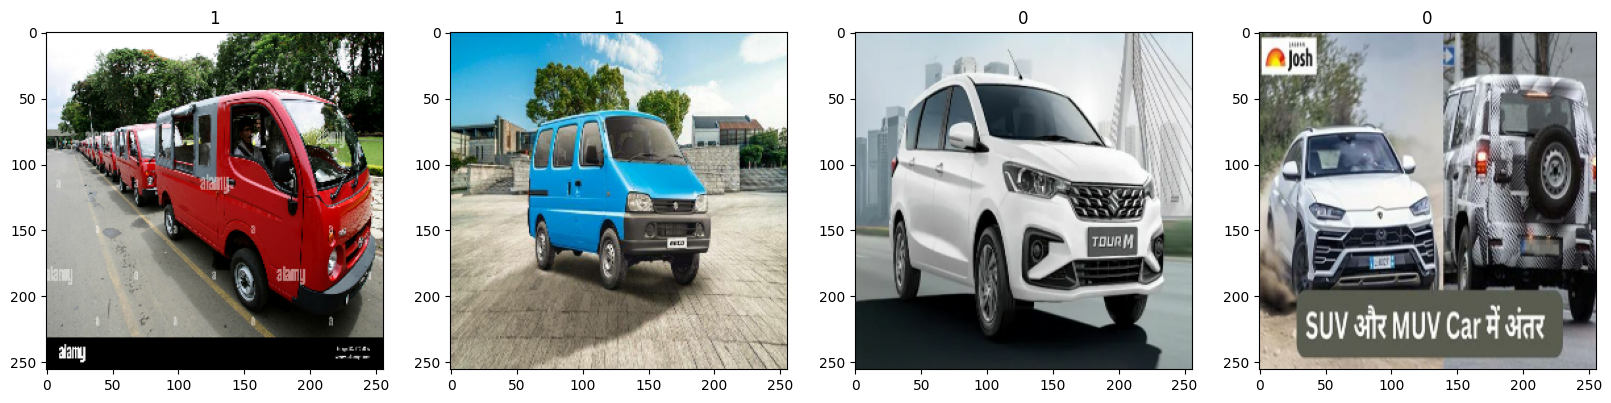

In [ ]:
batch = data_iterator.next()
batch[1] #labels
batch[0] #images represented as numpy array


fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

#class 1 --> VAN
#class 0 --> MUV

PREPROCESSING DATA

In [ ]:
#scale data
data = data.map(lambda x, y: (x/255, y))

In [ ]:
#split data
train_size = int(len(data) * 0.7);
val_size = int(len(data) * 0.2);
test_size = int(len(data) * 0.1) + 1;

train = data.take(train_size);
val = data.skip(train_size).take(val_size);
test = data.skip(train_size + val_size).take(test_size);

BUILDING THE DEEP LEARNING MODEL

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape = (256, 256, 3))) #no. of filters, size of filters, stride
                                                                                  #relu converts negative values to 0
model.add(MaxPooling2D())


model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile('adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#train model
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir) #logs to keeps track of progress

hist = model.fit(train, epochs = 20, validation_data=val, callbacks = [tensorboard_callback] )


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.5247 - loss: 1.0497 - val_accuracy: 0.4688 - val_loss: 0.9772
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5378 - loss: 1.0540 - val_accuracy: 0.5938 - val_loss: 0.6744
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.4909 - loss: 0.7717 - val_accuracy: 0.6250 - val_loss: 0.6374
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.5169 - loss: 0.7068 - val_accuracy: 0.6875 - val_loss: 0.5865
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5573 - loss: 0.6493 - val_accuracy: 0.8750 - val_loss: 0.6155
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.7969 - loss: 0.6173 - val_accuracy: 0.8438 - val_loss: 0.5627
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.6458 - loss: 0.6203 - val_accuracy: 0.7500 - val_loss: 0.5317
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.8555 - loss: 0.5015 - val_accuracy: 0.6875 - val_loss: 0.5674
Epoch 9/20
3/3

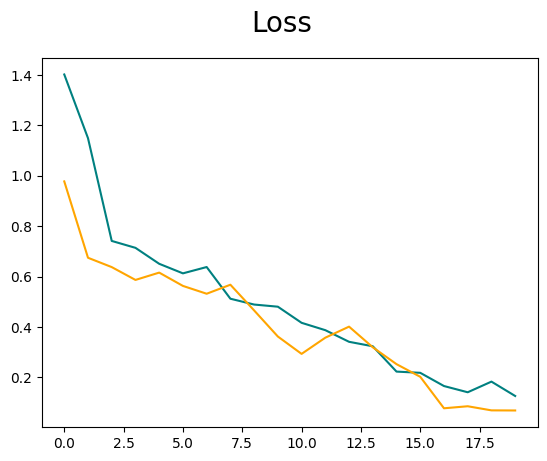

In [ ]:
#plot performance
fig = plt.figure()
plt.plot(hist.history['loss'], color = "teal", label = "loss")
plt.plot(hist.history['val_loss'], color = "orange", label = "val_loss")
fig.suptitle("Loss", fontsize = 20)
plt.show()

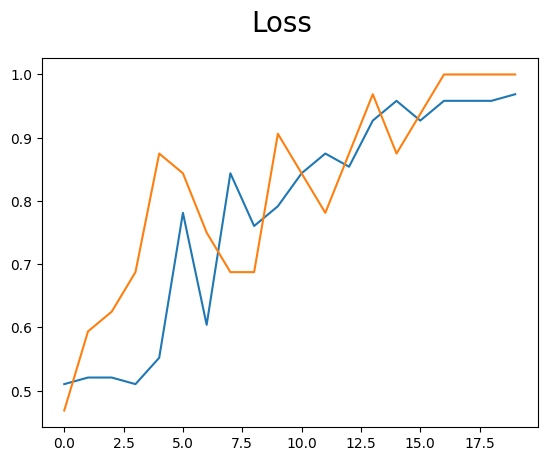

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], label = "accuracy")
plt.plot(hist.history['val_accuracy'], label = "val_accuracy")
fig.suptitle("Loss", fontsize = 20)
plt.show()

EVALUATE PERFORMANCE

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

precision = Precision()
acc = BinaryAccuracy()
recall = Recall()

for batch in test.as_numpy_iterator():
  X, y = batch
  y_pred = model.predict(X)
  precision.update_state(y, y_pred)
  acc.update_state(y, y_pred)
  recall.update_state(y, y_pred)

print("Precision: ", precision.result().numpy())
print("Accuracy: ", acc.result().numpy())
print("Recall: ", recall.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
Precision:  0.93333334
Accuracy:  0.96
Recall:  1.0


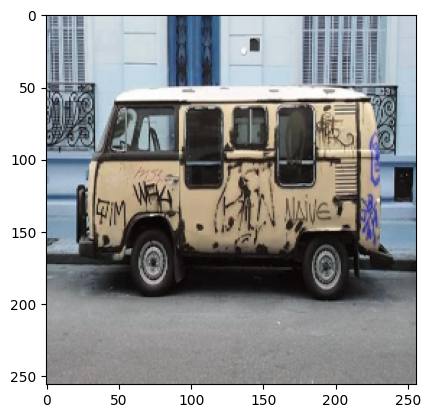

In [ ]:
#test
import cv2

img = cv2.imread("drive/MyDrive/test_images/van_test.jpg")
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
y_pred = model.predict(np.expand_dims(resize/255, 0))
print(y_pred)
if(y_pred < 0.5):
  print("Predicted: MUV")
else:
  print("Predicted: Van")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
[[0.9785413]]
Predicted: Van


SAVE MODEL

In [ ]:
from tensorflow.keras.models import load_model

model.save(os.path.join("drive/MyDrive/models", "Indian_Vehicle_Classifier.h5"))

In [ ]:
#new-model = load_model(path)